In [1]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
# Load the dataset
sales_data = pd.read_csv("sales.csv")

In [3]:
# Check the data if all columns are numbers
sales_data.dtypes

Unnamed: 0              int64
store_ID                int64
day_of_week             int64
date                   object
nb_customers_on_day     int64
open                    int64
promotion               int64
state_holiday          object
school_holiday          int64
sales                   int64
dtype: object

In [4]:
# Print dataframe head to inspect data
sales_data.head()

,Unnamed: 0,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
0,425390,366,4,2013-04-18,517,1,0,0,0,4422
1,291687,394,6,2015-04-11,694,1,0,0,0,8297
2,411278,807,4,2013-08-29,970,1,1,0,0,9729
3,664714,802,2,2013-05-28,473,1,1,0,0,6513
4,540835,726,4,2013-10-10,1068,1,1,0,0,10882


In [5]:
# Rename unnamed first column
sales_data.rename(columns={'Unnamed: 0':'something'}, inplace=True)
sales_data.head()

,something,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
0,425390,366,4,2013-04-18,517,1,0,0,0,4422
1,291687,394,6,2015-04-11,694,1,0,0,0,8297
2,411278,807,4,2013-08-29,970,1,1,0,0,9729
3,664714,802,2,2013-05-28,473,1,1,0,0,6513
4,540835,726,4,2013-10-10,1068,1,1,0,0,10882


In [6]:
# Only keep month of date column (and convert to integer) to account for seasonal fluctuations in sales 
# Drop date, unnamed and store ID columns as these are not informative for the model
sales_data["month"] = pd.to_numeric(sales_data['date'].str[5:7])
sales_data.drop(["something", "store_ID", "date"], axis = "columns", inplace=True)
sales_data.head()

,day_of_week,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales,month
0,4,517,1,0,0,0,4422,4
1,6,694,1,0,0,0,8297,4
2,4,970,1,1,0,0,9729,8
3,2,473,1,1,0,0,6513,5
4,4,1068,1,1,0,0,10882,10


In [7]:
# Handling with categorical variables, etc.
sales_data['state_holiday'].value_counts()

state_holiday
0    621160
a     12842
b      4214
c      2624
Name: count, dtype: int64

In [8]:
# Apply label encoding to 'state_holiday' column
sales_data['state_holiday'] = LabelEncoder().fit_transform(sales_data['state_holiday'])

# Check of the State holiday has been replaced correctly
sales_data['state_holiday'].value_counts()

state_holiday
0    621160
1     12842
2      4214
3      2624
Name: count, dtype: int64

In [9]:
# Select the continuous columns to scale
columns_to_scale = ['nb_customers_on_day', 'sales', 'promotion']

# Apply MinMax scaling to the selected columns
sales_data[columns_to_scale] = MinMaxScaler().fit_transform(sales_data[columns_to_scale])

# Display the first few rows to verify scaling
sales_data[columns_to_scale].head()

,nb_customers_on_day,sales,promotion
0,0.094723,0.106423,0.0
1,0.127153,0.199682,0.0
2,0.177721,0.234146,1.0
3,0.086662,0.156747,1.0
4,0.195676,0.261895,1.0


In [10]:
# Set plot style
plt.style.use('ggplot')

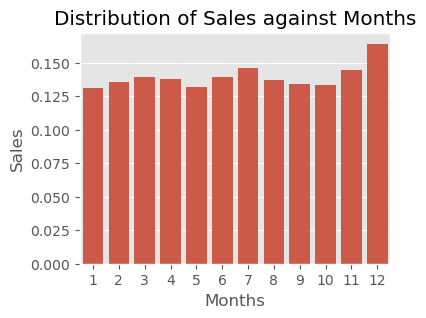

In [11]:
# Analyze the distribution of the 'sales' variable against the months of the year
plt.figure(figsize=(4, 3))
sns.barplot(x="month", y="sales", data=sales_data, errorbar=None)
plt.title('Distribution of Sales against Months')
plt.xlabel('Months')
plt.ylabel('Sales')
plt.show()


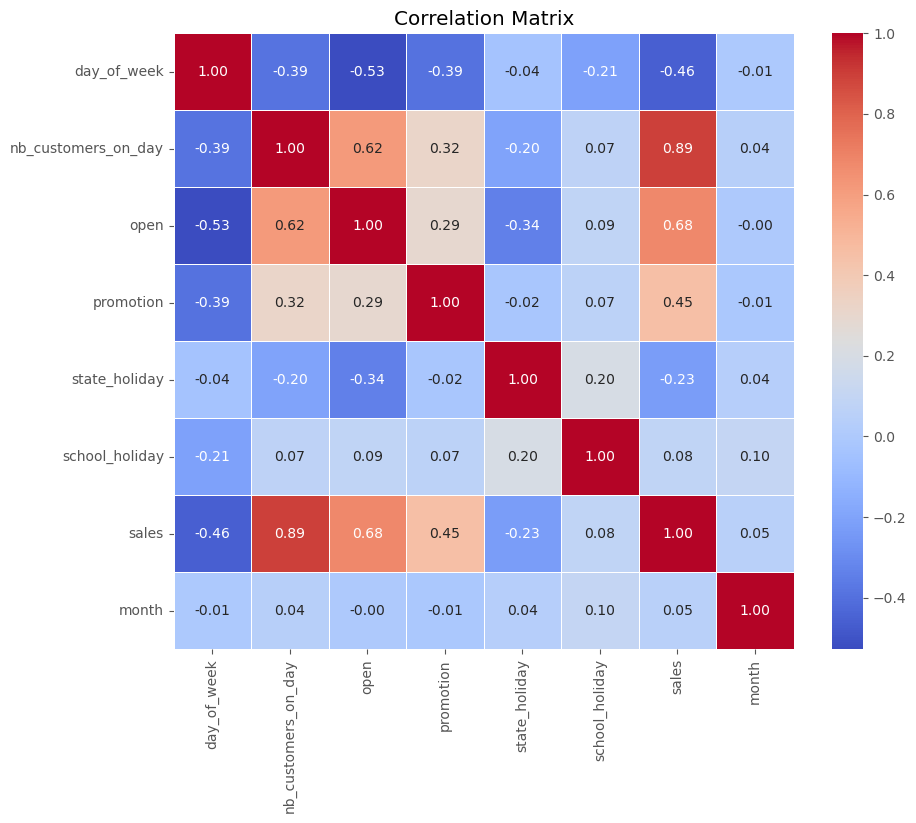

In [12]:
# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = sales_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [13]:
#Define test_data as the complete file is very big. Tag 50% for defining best model
test_data = sales_data[0:int(int(sales_data.size) * 0.25)]

In [14]:
X = test_data.drop(columns=['sales'])
y = test_data['sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Initialize models
models = {
    #'Linear Regression': LinearRegression(),
    #'Descision Tree 1': DecisionTreeRegressor(max_depth=3),
    #'Descision Tree 2': DecisionTreeRegressor(max_depth=5),
    #'Descision Tree 3': DecisionTreeRegressor(max_depth=7),
    #'Descision Tree 8': DecisionTreeRegressor(max_depth=8),
    #'Descision Tree 9': DecisionTreeRegressor(max_depth=9),
    #'Descision Tree 10': DecisionTreeRegressor(max_depth=10),
    #'Gradient Boosting 1': GradientBoostingRegressor(max_depth=3),
    #'Gradient Boosting 2': GradientBoostingRegressor(max_depth=5),
    #'Gradient Boosting 3': GradientBoostingRegressor(max_depth=7),
    #'XGBoost': XGBRegressor()
    #'SVM RBF': svm.SVR(kernel='rbf'),
    'SVM Linear': svm.SVR(kernel='linear'),
    #'SVM Polynomial': svm.SVR(kernel='polynomial'),
    #'KNN 3': KNeighborsRegressor(n_neighbors=3),
    #'KNN 5': KNeighborsRegressor(n_neighbors=5),
    #'KNN 10': KNeighborsRegressor(n_neighbors=10),
    #'KNN 15': KNeighborsRegressor(n_neighbors=15),
    #'XGBoost': XGBRegressor(booster = "gblinear"),
    #'XGBoost 2': XGBRegressor(booster = "dart")
}

# Step 3: Train and evaluate models
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on test data
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    # Print performance metrics
    print(f"{name} - R²: {r2:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

    

## Models tested:

1. Linear Regression - R²: 0.85, RMSE: 0.04, MAE: 0.02

2. Descision Tree

    a) Descision Tree Depth 3 - R²: 0.81, RMSE: 0.04, MAE: 0.03

    b) Descision Tree Depth 5 - R²: 0.86, RMSE: 0.04, MAE: 0.02

    c) Descision Tree Depth 7 - R²: 0.87, RMSE: 0.03, MAE: 0.02

    d) Descision Tree Depth 8 - R²: 0.87, RMSE: 0.03, MAE: 0.02

    e) Descision Tree Depth 9 - R²: 0.88, RMSE: 0.03, MAE: 0.02

    f) Descision Tree Depth 10 - R²: 0.88, RMSE: 0.03, MAE: 0.02

3. Random Forest - Performance not better than Descision Tree

4. Gradient Boosting 

    a) Gradient Boosting Depth 3 - R²: 0.88, RMSE: 0.03, MAE: 0.02

    b) Gradient Boosting Depth 5 - R²: 0.88, RMSE: 0.03, MAE: 0.02

    c) Gradient Boosting Depth 7 - R²: 0.88, RMSE: 0.03, MAE: 0.02
    
5. XGBoost - R²: 0.88, RMSE: 0.03, MAE: 0.02 


KNN 3 - R²: 0.84, RMSE: 0.04, MAE: 0.02 - half
KNN 5 - R²: 0.86, RMSE: 0.03, MAE: 0.02 - half
KNN 10 - R²: 0.87, RMSE: 0.03, MAE: 0.02 - half
KNN 15 - R²: 0.87, RMSE: 0.03, MAE: 0.02 - full

XGBoost linear - R²: 0.85, RMSE: 0.04, MAE: 0.02 
XGBoost dart - R²: 0.88, RMSE: 0.03, MAE: 0.02 

svm - takes too long

We also checked for feature importance and dropped unimportant columns ("month", "school_holiday", "state_holiday", "open"), but results were worse than on the full model

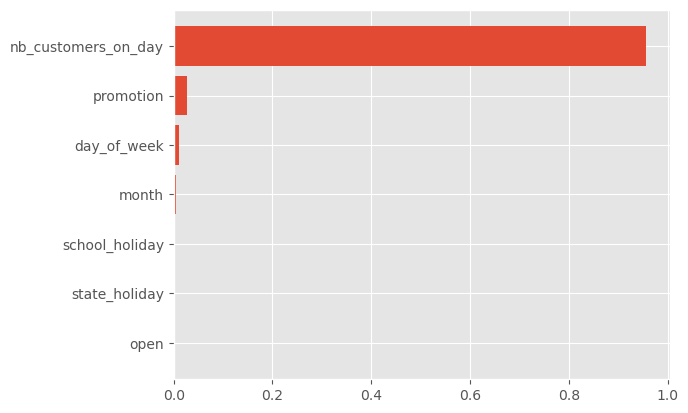

In [59]:
sort_idx = model.feature_importances_.argsort()
plt.barh(X.columns[sort_idx],model.feature_importances_[sort_idx])
plt.show();